In [1]:
import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')
cluster_group_data = pd.read_csv('Data/cluster_group.csv')


stop_data = pd.read_csv('Data/stops.csv')
general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join(cluster_group_data.join(bus_stop_data.join(date_data.join(meta_data))))
# data_set['start_date'] = pd.to_datetime(data_set['start_date'], infer_datetime_format=True)
# data_set.set_index('start_date', inplace=True)
from scipy import stats

general_np = general.to_numpy()

In [2]:
data_set

,startx,starty,endx,endy,start_cluster_group,end_cluster_group,start_near_stop,end_near_stop,start_date,start_hour,...,nursing_hm,sing_famly,town_house,twn_na,twn_no_res,twn_occpd,twn_owned,twn_person,twn_uc,twn_vacant
0,-114.094432,51.038086,-114.087536,51.037255,65,138,1,1,7/15/2019,0,...,0,71,341,0,5,318,114,543,1,16
1,-114.094425,51.034740,-114.076043,51.036427,65,138,1,1,7/15/2019,0,...,0,794,13,0,0,13,0,26,0,0
2,-114.092129,51.035578,-114.076043,51.036427,65,138,0,1,7/15/2019,0,...,0,794,13,0,0,13,0,26,0,0
3,-114.092172,51.057330,-114.089868,51.054822,16,26,1,0,7/15/2019,0,...,1,991,113,0,0,105,55,232,4,4
4,-114.089845,51.043110,-114.071442,51.033083,133,89,1,1,7/15/2019,0,...,0,71,341,0,5,318,114,543,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459473,-114.034679,51.041466,-114.059959,51.038946,62,1,1,0,9/27/2019,23,...,0,840,331,0,0,319,236,657,0,12
459474,-114.034679,51.041466,-114.059959,51.038946,62,1,1,0,9/27/2019,23,...,0,840,331,0,0,319,236,657,0,12
459475,-114.032381,51.042303,-114.059959,51.038946,62,1,1,0,9/27/2019,23,...,0,840,331,0,0,319,236,657,0,12
459476,-114.032380,51.040630,-114.036978,51.042302,62,62,1,1,9/27/2019,23,...,0,840,331,0,0,319,236,657,0,12


In [3]:
Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy', 'end_cluster_group','start_date', 'end_near_stop']).to_numpy()

In [4]:
import progressbar

X_sets_by_day = []
Y_sets_by_day = []

hr = 0
x = []
y = []

compare_hr_before = 0
compare_hr_current = 0
for i in progressbar.progressbar(range(len(X_data))):
    compare_hr_current = data_set['start_hour'][i]
    if (compare_hr_before == 23 and compare_hr_current == 0):
        hr = 0
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)
        x = []
        y = []
    compare_hr_before = data_set['start_hour'][i]
    x.append(X_data[i])
    y.append(Y_data[i])
    if i == (len(X_data) - 1):
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)
        


100% (459478 of 459478) |################| Elapsed Time: 0:00:06 Time:  0:00:06


In [5]:
W = 32
H = 32
map_mat = np.zeros((W,H))

map_set_by_day = []

for i in progressbar.progressbar(range(len(X_sets_by_day))):
    map_set_by_day.append([])
    x_now_day = np.asarray(X_sets_by_day[i])
    for j in range(len(X_sets_by_day[i])):
        X_day = X_sets_by_day[i][j][0]*100
        Y_day = X_sets_by_day[i][j][1]*100
        map_set_by_day[i].append(map_mat.copy())
        left = X_day - 5
        right = X_day + 5
        top = Y_day + 5
        bottom = Y_day - 5
        X_near = x_now_day[0:(j+1)]
        X_near = X_near[np.logical_and( X_near[:,4] == X_near[j,4] ,np.logical_and(np.logical_and(X_near[:,0]*100 >= left,  X_near[:,0]*100 <= right), np.logical_and(X_near[:,1]*100 >= bottom,  X_near[:,1]*100 <= top)))]
        
        for x_n in range(len(X_near)):
            xn_tranform_x = int(W*((X_near[x_n][0]*100) - left)/(right - left))
            xn_tranform_y = int(H*((X_near[x_n][1]*100) - bottom)/(top - bottom))
            map_set_by_day[i][j][xn_tranform_x,xn_tranform_y] = 1
            
        tranform_x = int(W*(X_day - left)/(right - left))
        tranform_y = int(H*(Y_day - bottom)/(top - bottom))
        map_set_by_day[i][j][tranform_x, tranform_y] = 2

100% (75 of 75) |########################| Elapsed Time: 0:04:48 Time:  0:04:48


In [6]:
X_train_set = []
Y_train_set = []
Map_X_train_set = []
for i in progressbar.progressbar(range(48)):
    for j in range(len(X_sets_by_day[i])):
        X_train_set.append(X_sets_by_day[i][j])
        Y_train_set.append(Y_sets_by_day[i][j])
        Map_X_train_set.append(map_set_by_day[i][j])

X_test_set = []
Y_test_set = []
Map_X_test_set = []
for i in progressbar.progressbar(range(48,len(X_sets_by_day))):
    for j in range(len(X_sets_by_day[i])):
        X_test_set.append(X_sets_by_day[i][j])
        Y_test_set.append(Y_sets_by_day[i][j])
        Map_X_test_set.append(map_set_by_day[i][j])
        
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.callbacks import EarlyStopping

X_train_set = np.asarray(X_train_set)
X_test_set = np.asarray(X_test_set)
scx = MinMaxScaler(feature_range=(0,1))
X_train_set_fit = scx.fit_transform(X_train_set)
X_test_set_fit = scx.transform(X_test_set)

Y_train_set = np.asarray(Y_train_set)
Y_test_set = np.asarray(Y_test_set)
scy = MinMaxScaler(feature_range=(0,1))
Y_train_set_fit = scy.fit_transform(Y_train_set)
Y_test_set_fit = scy.transform(Y_test_set)

Map_X_train_set = np.asarray(Map_X_train_set)
Map_X_test_set = np.asarray(Map_X_test_set)

Map_X_train_set = Map_X_train_set.reshape(len(Map_X_train_set), Map_X_train_set.shape[1], Map_X_train_set.shape[2], 1)
Map_X_test_set = Map_X_test_set.reshape(len(Map_X_test_set), Map_X_test_set.shape[1], Map_X_test_set.shape[2], 1)



100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/Users/norma/anaconda3/envs/geo_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/norma/anaconda3/envs/geo_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/norma/anaconda3/envs/geo_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future vers

In [52]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, RNN, Embedding
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from copy import copy


inputA = layers.Input(shape=(5))
inputB = layers.Input(shape=(60))

shape = Map_X_train_set.shape
inputMap = layers.Input(shape=(shape[1],shape[2],1))
mapx = Conv2D(filters=32, kernel_size=(4,4), input_shape=(shape[1],shape[2]), activation='relu',)(inputMap)
mapx = MaxPooling2D(pool_size=(2, 2))(mapx)
mapx = Flatten()(mapx)
mapx = Model(inputs=inputMap, outputs=mapx)




x = Dense(32)(inputA)
x = Dense(15, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

y = Dense(70)(inputB)
y = Dense(65, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
final_xy = Dense(25, activation="sigmoid")(layers.concatenate([x.output, y.output]))

final_cnn = Dense(15, activation="sigmoid")(layers.concatenate([x.output, mapx.output]))

# x_lstm = Embedding(input_dim=5, output_dim=15)(inputA)
# # x_lstm = LSTM(10)(x_lstm)

# final = Dense(15, activation="sigmoid")(layers.concatenate([final_cnn, final_xy]))
# final = Dropout(0.2)(final)
c = Dense(2)(final_cnn)


model = Model(inputs=[x.input,y.input, mapx.input], outputs=c)
model.compile(loss="mean_absolute_error", optimizer="adam")

ERROR! Session/line number was not unique in database. History logging moved to new session 90


In [53]:
from tensorflow.python.keras.callbacks import EarlyStopping

model.compile(loss="mean_absolute_error", optimizer="adam", metrics=['acc'])

callback = EarlyStopping(monitor='val_loss', patience=5, mode="auto")
# history = model.fit([x_train[:,0:7],x_train[:,7:]], [y_train[:,0:2], y_train[:,2:4]], epochs=100, validation_data=([x_test[:,0:7],x_test[:,7:]], [y_test[:,0:2], y_test[:,2:4]]))

history = model.fit([X_train_set_fit[:,0:5],X_train_set_fit[:,5:], Map_X_train_set], Y_train_set_fit, epochs=100, validation_data=([X_test_set_fit[:,0:5],X_test_set_fit[:,5:], Map_X_test_set], Y_test_set_fit))

Train on 272446 samples, validate on 187032 samples
Epoch 1/100
272446/272446 [==============================] - 74s 271us/sample - loss: 0.0220 - acc: 0.7409 - val_loss: 0.0191 - val_acc: 0.7476
Epoch 2/100
272446/272446 [==============================] - 74s 273us/sample - loss: 0.0194 - acc: 0.7563 - val_loss: 0.0211 - val_acc: 0.7246
Epoch 3/100
272446/272446 [==============================] - 73s 268us/sample - loss: 0.0193 - acc: 0.7573 - val_loss: 0.0188 - val_acc: 0.7507
Epoch 4/100
272446/272446 [==============================] - 73s 267us/sample - loss: 0.0193 - acc: 0.7576 - val_loss: 0.0191 - val_acc: 0.7449
Epoch 5/100
272446/272446 [==============================] - 73s 269us/sample - loss: 0.0192 - acc: 0.7582 - val_loss: 0.0189 - val_acc: 0.7534
Epoch 6/100
272446/272446 [==============================] - 75s 275us/sample - loss: 0.0191 - acc: 0.7577 - val_loss: 0.0198 - val_acc: 0.7376
Epoch 7/100
272446/272446 [==============================] - 73s 269us/sample - loss

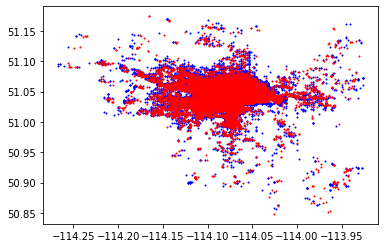

In [54]:
import matplotlib.pyplot as plt
import numpy as np
result_Y = (model.predict([X_test_set_fit[:,0:5],X_test_set_fit[:,5:], Map_X_test_set]))

result_Y_plot = scy.inverse_transform(result_Y)
y_test_plot = scy.inverse_transform(Y_test_set_fit)

plt.scatter((y_test_plot[:,0]),(y_test_plot[:,1]), color='b', s= 1)
plt.scatter((result_Y_plot[:,0]), (result_Y_plot[:,1]), color='r', s= 1)



In [55]:
result = model.predict([X_test_set_fit[:,0:5],X_test_set_fit[:,5:], Map_X_test_set])

In [56]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

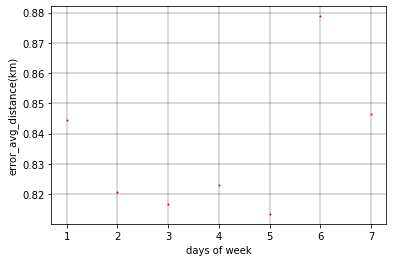

In [57]:
mae_rate_day_of_week = []

x_test_day = scx.inverse_transform(X_test_set_fit)
result_Y_day = scy.inverse_transform(result)
y_test_day = scy.inverse_transform(Y_test_set_fit)
for index in range(7):
    mask = np.logical_and(x_test_day[:,5] > (index)-0.1, x_test_day[:,5] < (index+1)-0.1)
    result_Y_d_day = result_Y_day[mask]
    Y_test_in = y_test_day[mask]
    error = 0
    haverList = []
    for i in (range(len(Y_test_in))):
        error = error + haversine(result_Y_d_day[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    mae_rate_day_of_week.append([error_average_distance, str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)

In [58]:
result_Y_all = scy.inverse_transform(result_Y)
y_test_all = scy.inverse_transform(Y_test_set_fit)
error_all = 0
for i in (range(len(y_test_all))):
    error_all = error_all + haversine(result_Y_all[i],y_test_all[i])
    error_avg = error_all/len(y_test_all)
error_avg

0.8350215829911628